# **SENTIMENT ANALYSIS ON POLITICAL DISCOURSE USING TWITTER DATA AHEAD OF 2020 US POLLS**

According to popular tech website GeeksforGeeks, sentiment analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

Sentiment analysis is used by a number of data analytics companies on a variety of subjects. Some of the popular markets where it is used are:


*   **Business**: The marketing team of many companies use it to create business strategies, to understand how customers perceive their product and to understand customer behavior in order to improve sales.
*   **Politics**: In the political field, it is used to keep track of regions where the candidate is favourable and work towards regions where the candidate is not favourable in order to improve their chances in an election.



The US Presidential Elections are scheduled to be held on the 3rd of November and with less than a week left, this was a good time to understand the public mood and opinion in different US states towards the candidates - Republican current president Donald Trump and Democratic challenger Joe Biden.

For this analysis, I have collected tweets made over the last week using Twitter's publicly available API and performed sentiment analysis of those tweets using VADER Sentiment Analysis.

In [ ]:
!pip install ConfigParser

# Data Wrangling

In order to use the Twitter API, we need to have a Twitter Developer Account which gives us access to an access token, an access token secret, an api key and an api secret key. I have noted these parameters inside a properties file which I placed inside one of my drive folders. I used python's configparser to read those data in order to use the twitter API.

In [ ]:
import configparser
config = configparser.RawConfigParser()
config.read('/content/drive/My Drive/Colab Notebooks/twitter.properties')
print(config.sections());

['twitter']


In [ ]:
import os
import tweepy as tw
import pandas as pd

In [ ]:
accesstoken = config.get('twitter','accesstoken')
accesstokensecret = config.get('twitter','accesstokensecret')
apikey = config.get('twitter','apikey')
apisecretkey = config.get('twitter','apisecretkey')

In [ ]:
auth = tw.OAuthHandler(apikey, apisecretkey)
auth.set_access_token(accesstoken, accesstokensecret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
search_words = "Joe Biden" # This will be changed to Donald Trump when we retrieve tweets related to him.
date_since = "2020-10-27"

Twitter uses pagination a lot in their API development. In order to perform pagination, Twitter supplies a page/cursor parameter with each of their requests. As a result, this requires a lot of boiler plate code just to manage the pagination loop. To help make pagination easier and require less code the Twitter API or Tweepy has the Cursor object.

Now, since the Cursor is passed callable, we can not pass the parameters directly into the method. Instead the parameters are passed into the Cursor constructor method. For our api to search tweets, we pass the following parameters:

1.   q: This is the keyword to be searched in the tweet. For our project, we pass the name of the candidate (Donald Trump/Joe Biden).
2.   lang: This is the language of the tweets we want to retrieve from the API. Since USA is largely an English-speaking country with English also being the official language, we retrieve tweets made in English.
3. since: This is the date from which we want to retrieve tweets. For our purposes, we are interested in the current political discourse to understand the current mood ahead of the elections. So we pass this as last Tuesday, which is one week before the elections are to be held.

Another factor which needs to be kept in mind is the tweepy search api retrieves a maximum of 1500 tweets at a time followed by a cooldown period of 15 minutes.



In [ ]:
tweets = tw.Cursor(api.search, q=search_words, lang="en", since=date_since).items(100)

In [ ]:
tweets

The result of the search api call is a cursor item iterator object. From this iterator object, we iterate through pick up the geo, text, username and location details. Some details like geo and location details are dependent on whether the particular user is sharing these details or not. If the user is not sharing these details, we will get blank data for these columns.

Afterwards, we convert our list to a pandas dataframe.

In [ ]:
tweet_details = [[tweet.geo, tweet.text, tweet.user.screen_name, tweet.user.location] for tweet in tweets]

In [ ]:
tweet_df = pd.DataFrame(data=tweet_details, columns=["geo","text","user","location"])

In [ ]:
pd.set_option('max_colwidth',800)
tweet_df.head(20)

,geo,text,user,location
0,None,RT @davidicke: Co-founder Glenn Greenwald resigns from the ‘free’ Intercept after they censored his story about Joe Biden’s monumental and…,Wakeupnowy,
1,None,RT @ProjectLincoln: A vote for Joe Biden is a vote for Puerto Rico. We must never forget Donald Trump's inactions led to the loss of over 3…,OkanaganLeigh,
2,None,"RT @HKrassenstein: Now that NBC has exposed the bogus Hunter Biden smears and discovered that a fake man named ""Martin Aspen"" was behind it…",jessicar1980681,
3,None,"RT @JoeBiden: After campaigning in 2016 to lift up the ‘forgotten man,’ President Trump has completely lost sight of working people. \n\nI pr…",youarenotBert,
4,None,RT @DrJasonJohnson: You know why most of the #HunterBiden stories never made much sense to me? Because Joe Biden was in the White House fro…,JesseSimonODay,"Oswego, NY"
5,None,"RT @EvanAKilgore: .@realDonaldTrump has THREE Make America Great Again peaceful protests today.\n\n📍Waterford Town, MI: 1:00 p.m. (EST)\n\n📍Gre…",drewCor01177630,
6,None,"RT @JoeBiden: After campaigning in 2016 to lift up the ‘forgotten man,’ President Trump has completely lost sight of working people. \n\nI pr…",LiReHirsch,Philadelphia
7,None,RT @ProjectLincoln: A vote for Joe Biden is a vote for Puerto Rico. We must never forget Donald Trump's inactions led to the loss of over 3…,mrmrf8,
8,None,RT @ProjectLincoln: A vote for Joe Biden is a vote for Puerto Rico. We must never forget Donald Trump's inactions led to the loss of over 3…,sunshinek67,Texas
9,None,"RT @JoeBiden: After campaigning in 2016 to lift up the ‘forgotten man,’ President Trump has completely lost sight of working people. \n\nI pr…",foltat,"Storrs, CT USA"


Looking at the tweet texts, we notice that there are lot of characters which do not add any value towards sentiment analysis. Many of the tweets are preceeded with RT which indicates the tweet was retweeted. The tweets are also preceeded with the name of the user from whom the tweet was retweeted which is also an information we are not concerned. We also remove any html website links which maybe present inside the tweet. All of these data cleaning are done with the help of the re built-in package of Python.

In [ ]:
import re
def clean_tweets(text):
  text = re.sub("RT @[\w]*:","",text)
  text = re.sub("@[\w]*","",text)
  text = re.sub("https?://[A-Za-z0-9./]*","",text)
  text = re.sub("\n","",text)
  return text

In [ ]:
tweet_df['text'] = tweet_df['text'].apply(lambda x: clean_tweets(x))
tweet_df['Subject'] = search_words
tweet_df.head(20)

,geo,text,user,location,Subject
0,None,Co-founder Glenn Greenwald resigns from the ‘free’ Intercept after they censored his story about Joe Biden’s monumental and…,Wakeupnowy,,Joe Biden
1,None,A vote for Joe Biden is a vote for Puerto Rico. We must never forget Donald Trump's inactions led to the loss of over 3…,OkanaganLeigh,,Joe Biden
2,None,"Now that NBC has exposed the bogus Hunter Biden smears and discovered that a fake man named ""Martin Aspen"" was behind it…",jessicar1980681,,Joe Biden
3,None,"After campaigning in 2016 to lift up the ‘forgotten man,’ President Trump has completely lost sight of working people. I pr…",youarenotBert,,Joe Biden
4,None,You know why most of the #HunterBiden stories never made much sense to me? Because Joe Biden was in the White House fro…,JesseSimonODay,"Oswego, NY",Joe Biden
5,None,". has THREE Make America Great Again peaceful protests today.📍Waterford Town, MI: 1:00 p.m. (EST)📍Gre…",drewCor01177630,,Joe Biden
6,None,"After campaigning in 2016 to lift up the ‘forgotten man,’ President Trump has completely lost sight of working people. I pr…",LiReHirsch,Philadelphia,Joe Biden
7,None,A vote for Joe Biden is a vote for Puerto Rico. We must never forget Donald Trump's inactions led to the loss of over 3…,mrmrf8,,Joe Biden
8,None,A vote for Joe Biden is a vote for Puerto Rico. We must never forget Donald Trump's inactions led to the loss of over 3…,sunshinek67,Texas,Joe Biden
9,None,"After campaigning in 2016 to lift up the ‘forgotten man,’ President Trump has completely lost sight of working people. I pr…",foltat,"Storrs, CT USA",Joe Biden


In this analysis, we are mostly concerned with finding the political mood of each and every US state currently from the twitter data. In order to do this, we need to do some more filtering with the original data which we extracted from the tweepy API. As we discussed before, the tweepy API provides us with the location of the user who made the tweet provided he/she is sharing this information with us. This location data is mostly blank. For others, it may consist of the country name only, city name only or the city and state separated by a comma and so on.

In the next part, we form a list of US states and another list of US state codes in order to extract tweets which contain these in the location record. 

P.S. This is a very naive way to do this cleansing. A much better way would have been to use the Google Maps API and get the state information from the location data provided it was in United States of America. However, due to problems with my Google Maps Billing Account, I had to contend myself with the naive way.

In [ ]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
          'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
          'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New York', 'New Mexico', 'North Carolina',
          'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
          'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
stateCodes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
              'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
              'WA', 'WV', 'WI', 'WY']
stateMapping = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
                  'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
                  'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                  'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 
                  'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 
                  'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NY': 'New York', 
                  'NM': 'New Mexico', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                  'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                  'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT':  'Utah', 'VT': 'Vermont', 
                  'VA': 'Virginia', 'WA': 'Washington', 'WV':  'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
tweet_copied_df = tweet_df
for index, row in tweet_df.iterrows():
  flag = 0
  if row.location:
    locationSplit = row.location.split(',')
    for word in locationSplit:
      word_stripped = word.strip()
      if word_stripped in states:
        flag = 1
        row['state'] = word_stripped
      elif word_stripped in stateCodes:
        flag = 1
        row['state'] = stateMapping[word_stripped]
  if flag == 0:
    tweet_copied_df = tweet_copied_df.drop(index=index)
  else:
    tweet_copied_df.loc[index, 'state'] = row['state']

At the end, we append the cleaned data to an existing csv file to create a corpus of twitter data on which we will use our sentiment analyser. For the purposes of this project, I ran the above lines of code in a loop with an interval of 15 minutes in between every iteration.

In [ ]:
tweet_copied_df.to_csv('tweets_election.csv', header=False, mode='a')

# Sentiment Analysis

We use the VADER Sentiment Analyzer in order to perform the sentiment analysis. According to GeeksforGeeks, VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. A sentiment lexicon is a list of lexical features, in simpler terms words which are generally labeled according to their semantic orientation as either positive or negative. VADER not only categorizes a sentiment as positive or negative but also tells us how positive or negative a sentiment is.

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
sid = SentimentIntensityAnalyzer()

Next up, we separate out the tweets of the two candidates into separate dataframes.

In [4]:
tweets_election_df = pd.read_csv('tweets_election.csv')
tweets_trump = tweets_election_df[tweets_election_df.Subject == 'Donald Trump']
tweets_trump.drop(tweets_trump.columns[0], axis=1, inplace = True)
tweets_trump.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,geo,text,user,location,Subject,state
0,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey
1,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas
2,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts
3,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey
4,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota


In [5]:
tweets_biden = tweets_election_df[tweets_election_df.Subject == 'Joe Biden']
tweets_biden.drop(tweets_biden.columns[0], axis=1, inplace = True)
tweets_biden.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,geo,text,user,location,Subject,state
2928,NaN,Unfortunately she along with other politicia...,gmollo1115,"Georgia, USA",Joe Biden,Georgia
2929,NaN,Let’s talk about the Hunter laptop and such. ...,mcritter61,"Houston, TX",Joe Biden,Texas
2930,NaN,Fun to think about how we learned today that ...,1kingsbay,"on the river, FL",Joe Biden,Florida
2931,NaN,Larry Kudlow: Joe Biden's economic plan would...,JanedgeJanis,"Texas, USA",Joe Biden,Texas
2932,NaN,A 64-page document asserting an elaborate con...,denopotter,"Dallas, TX",Joe Biden,Texas


Text(0.5, 1.0, 'Comparison of Twitter mentions of both candidates in all US states as per data collected')

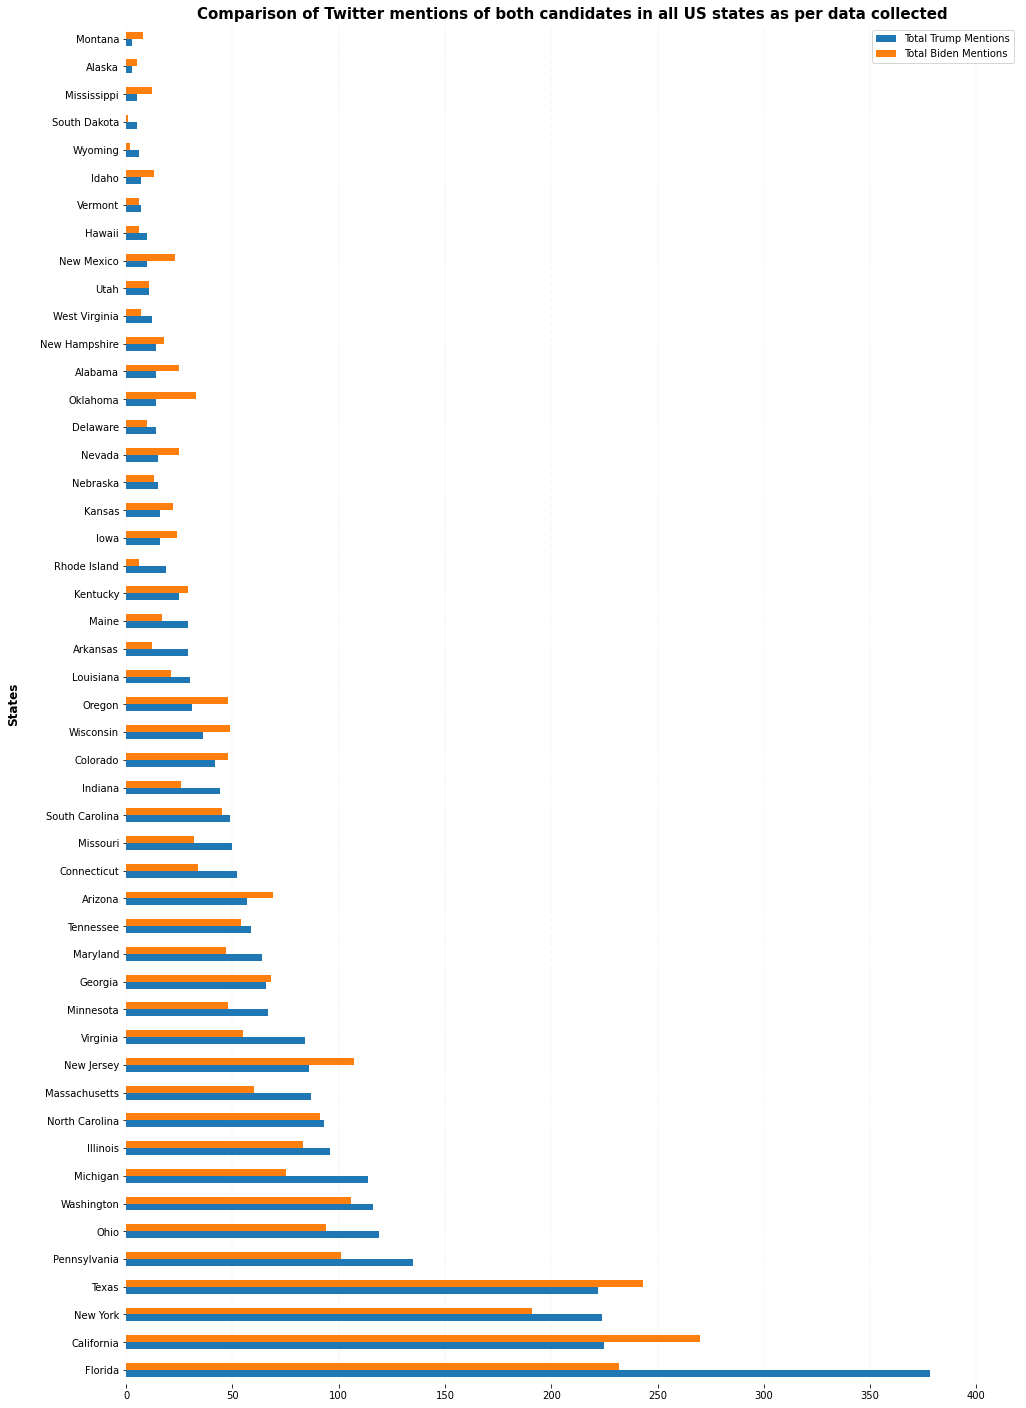

In [6]:
df = pd.merge(tweets_trump['state'].value_counts(), tweets_biden['state'].value_counts(), right_index = True, 
               left_index = True)
df = df.rename(columns = {"state_x": "Total Trump Mentions", "state_y": "Total Biden Mentions"})
ax = df.plot(kind='barh', figsize=(16, 25), zorder=2)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Replacing ticks with horizontal lines
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set y-axis label
ax.set_ylabel("States", labelpad=20, weight='bold', size=12)
ax.set_title('Comparison of Twitter mentions of both candidates in all US states as per data collected',fontweight="bold", size=15)

The above graphic shows a huge shortcoming of our analysis. Our dataset, like many other datasets is not a well distributed dataset. This means we have some states like Florida, California, Texas which have more data than others. Also, it seems that the amount of data related to Trump exceeds Biden's data by a small margin.

We proceed with our sentiment analysis now. To start off, we apply the polarity_scores() method to every tweet text in order to understand the sentiment of the tweet. The result of this method call is a dictionary showing the intensity of negative, neutral and positive sentiment in the tweet. All these three values are used to create the fourth figure which is the overall compound sentiment of the tweet. We will use this figure to judge whether the sentiment of a tweet is positive, negative or neutral.

In [8]:
tweets_trump['sentiment'] = tweets_trump['text'].apply(lambda x: sid.polarity_scores(x))
tweets_biden['sentiment'] = tweets_biden['text'].apply(lambda x: sid.polarity_scores(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
def sentimentVerdict(sentiment):
  if sentiment['compound'] >= 0.05:
    return "Positive"
  elif sentiment['compound'] <= -0.05:
    return "Negative"
  else:
    return "Neutral"

In [10]:
tweets_trump['sentiment_overall'] = tweets_trump['sentiment'].apply(lambda x: sentimentVerdict(x))
tweets_trump.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,geo,text,user,location,Subject,state,sentiment,sentiment_overall
0,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey,"{'neg': 0.181, 'neu': 0.819, 'pos': 0.0, 'comp...",Negative
1,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas,"{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'comp...",Negative
2,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts,"{'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...",Positive
3,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey,"{'neg': 0.251, 'neu': 0.566, 'pos': 0.184, 'co...",Negative
4,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota,"{'neg': 0.169, 'neu': 0.654, 'pos': 0.177, 'co...",Positive
5,NaN,'A vote for Donald Trump is a vote against the...,TMScarletFire,"Salem, MA",Donald Trump,Massachusetts,"{'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'comp...",Positive
6,NaN,There is no greater supporter of Donald Trump...,mwamsley5,Ohio,Donald Trump,Ohio,"{'neg': 0.169, 'neu': 0.654, 'pos': 0.177, 'co...",Positive
7,NaN,The same people who are outraged at AOC for s...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota,"{'neg': 0.299, 'neu': 0.613, 'pos': 0.088, 'co...",Negative
8,NaN,Donald Trump is on track to become the worst ...,XchargerFan619,"San Diego, CA",Donald Trump,California,"{'neg': 0.227, 'neu': 0.773, 'pos': 0.0, 'comp...",Negative
9,NaN,"It is Friday, October 30, 2020. One citizen, I...",eachlifeinplace,Iowa,Donald Trump,Iowa,"{'neg': 0.0, 'neu': 0.93, 'pos': 0.07, 'compou...",Positive


In [11]:
tweets_biden['sentiment_overall'] = tweets_biden['sentiment'].apply(lambda x: sentimentVerdict(x))
tweets_biden.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,geo,text,user,location,Subject,state,sentiment,sentiment_overall
2928,NaN,Unfortunately she along with other politicia...,gmollo1115,"Georgia, USA",Joe Biden,Georgia,"{'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'comp...",Negative
2929,NaN,Let’s talk about the Hunter laptop and such. ...,mcritter61,"Houston, TX",Joe Biden,Texas,"{'neg': 0.146, 'neu': 0.758, 'pos': 0.096, 'co...",Negative
2930,NaN,Fun to think about how we learned today that ...,1kingsbay,"on the river, FL",Joe Biden,Florida,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",Positive
2931,NaN,Larry Kudlow: Joe Biden's economic plan would...,JanedgeJanis,"Texas, USA",Joe Biden,Texas,"{'neg': 0.127, 'neu': 0.873, 'pos': 0.0, 'comp...",Negative
2932,NaN,A 64-page document asserting an elaborate con...,denopotter,"Dallas, TX",Joe Biden,Texas,"{'neg': 0.159, 'neu': 0.841, 'pos': 0.0, 'comp...",Negative
2933,NaN,He is a profoundly decent man: a man of faith...,afquillen,"Crossville, Tennessee",Joe Biden,Tennessee,"{'neg': 0.0, 'neu': 0.669, 'pos': 0.331, 'comp...",Positive
2934,NaN,"Every CNN show should end with ""I'm Joe Biden...",sistertoldjah,"Charlotte, North Carolina",Joe Biden,North Carolina,"{'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'comp...",Positive
2935,NaN,"Rest assured, that’s my best friend who wrot...",JFJMayer8,"Oregon, USA",Joe Biden,Oregon,"{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp...",Positive
2936,NaN,"Winston Churchill’s granddaughter, Edwina San...",jerryChromeX,"Texas, USA",Joe Biden,Texas,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
2937,NaN,If Sleepy Joe Biden is actually elected Presi...,weisarts,"San Francisco, CA",Joe Biden,California,"{'neg': 0.112, 'neu': 0.717, 'pos': 0.17, 'com...",Positive


Now that we have classified every tweet data as either positive, negative or neutral, we can group by state and understand the general opinion of the public of that state regarding a particular candidate. This is our next course of action.

In [12]:
tweets_trump_location = tweets_trump.groupby(['state', 'sentiment_overall']).count()
tweets_trump_location = tweets_trump_location['user']
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(tweets_trump_location)

state           sentiment_overall
Alabama         Negative               4
                Neutral                3
                Positive               7
Alaska          Neutral                1
                Positive               2
Arizona         Negative              17
                Neutral               20
                Positive              20
Arkansas        Negative               6
                Neutral               12
                Positive              11
California      Negative              87
                Neutral               51
                Positive              87
Colorado        Negative              14
                Neutral                9
                Positive              19
Connecticut     Negative              19
                Neutral               17
                Positive              16
Delaware        Negative               4
                Neutral                6
                Positive               4
Florida         Negativ

In [13]:
tweets_biden_location = tweets_biden.groupby(['state', 'sentiment_overall']).count()
tweets_biden_location = tweets_biden_location['user']
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(tweets_biden_location)

state           sentiment_overall
Alabama         Negative              10
                Neutral                9
                Positive               6
Alaska          Negative               2
                Neutral                1
                Positive               2
Arizona         Negative              24
                Neutral               18
                Positive              27
Arkansas        Negative               3
                Neutral                4
                Positive               5
California      Negative             115
                Neutral               68
                Positive              87
Colorado        Negative              17
                Neutral               13
                Positive              18
Connecticut     Negative              13
                Neutral               11
                Positive              10
Delaware        Negative               4
                Neutral                3
                Positiv

In [19]:
tweets_location_df = pd.DataFrame({'State': [state for state in states],
                                         'Trump Positive': [0 for state in states],
                                         'Trump Negative': [0 for state in states],
                                         'Trump Neutral': [0 for state in states],
                                         'Trump Total': [0 for state in states],
                                         'Biden Positive': [0 for state in states],
                                         'Biden Negative': [0 for state in states],
                                         'Biden Neutral': [0 for state in states],
                                         'Biden Total': [0 for state in states]})
tweets_location_df.set_index('State', inplace = True)
for state in states:
  positiveTrump, negativeTrump, neutralTrump, positiveBiden, negativeBiden, neutralBiden = 0, 0, 0, 0, 0, 0
  try:
    positiveTrump = tweets_trump_location[state]['Positive']
  except:
    positiveTrump = 0
  
  try:
    negativeTrump = tweets_trump_location[state]['Negative']
  except:
    negativeTrump = 0
  
  try:
    neutralTrump = tweets_trump_location[state]['Neutral']
  except:
    neutralTrump = 0
  
  try:
    positiveBiden = tweets_biden_location[state]['Positive']
  except:
    positiveBiden = 0
  
  try:
    negativeBiden = tweets_biden_location[state]['Negative']
  except:
    negativeBiden = 0
  
  try:
    neutralBiden = tweets_biden_location[state]['Neutral']
  except:
    neutralBiden = 0

  totalTrump = positiveTrump + negativeTrump + neutralTrump
  totalBiden = positiveBiden + negativeBiden + neutralBiden

  if totalTrump == 0:
    tweets_location_df.at[state, 'Trump Positive'], tweets_location_df.at[state, 'Trump Negative'], tweets_location_df.at[state, 'Trump Neutral'] = 0,0,0
  else:
    tweets_location_df.at[state, 'Trump Positive'] = round((positiveTrump/totalTrump)*100.0)
    tweets_location_df.at[state, 'Trump Negative'] = round((negativeTrump/totalTrump)*100.0)
    tweets_location_df.at[state, 'Trump Neutral'] = round((neutralTrump/totalTrump)*100.0)
  tweets_location_df.at[state, 'Trump Total'] = totalTrump
  
  if totalBiden == 0:
    tweets_location_df.at[state, 'Biden Positive'], tweets_location_df.at[state, 'Biden Negative'], tweets_location_df.at[state, 'Biden Neutral'] = 0,0,0
  else:
    tweets_location_df.at[state, 'Biden Positive'] = round((positiveBiden/totalBiden)*100.0)
    tweets_location_df.at[state, 'Biden Negative'] = round((negativeBiden/totalBiden)*100.0)
    tweets_location_df.at[state, 'Biden Neutral'] = round((neutralBiden/totalBiden)*100.0)
  tweets_location_df.at[state, 'Biden Total'] = totalBiden
tweets_location_df

,Trump Positive,Trump Negative,Trump Neutral,Trump Total,Biden Positive,Biden Negative,Biden Neutral,Biden Total
State,,,,,,,,
Alabama,50,29,21,14,24,40,36,25
Alaska,67,0,33,3,40,40,20,5
Arizona,35,30,35,57,39,35,26,69
Arkansas,38,21,41,29,42,25,33,12
California,39,39,23,225,32,43,25,270
Colorado,45,33,21,42,38,35,27,48
Connecticut,31,37,33,52,29,38,32,34
Delaware,29,29,43,14,30,40,30,10
Florida,37,34,29,378,31,31,37,232


To wrap up our analysis, we use the above analysis to classify whether a state is one of hthe following:

*   **Strongly Republican**: The number of positive tweets on Trump exceeds the same for Biden and the number of negative tweets on Trump is less than that of Biden or the number of tweets where the sentiment is neutral to Trump is more than that of Biden.
*   **Strongly Democratic**: The number of positive tweets on Biden exceeds the same for Trump and the number of negative tweets on Biden is less than that of Trump or the number of tweets where the sentiment is neutral to Biden is more than that of Trump.
* **Somewhat Republican**: The margin between positive Trump tweets and positive Biden tweets is more than the margin for negative tweets.
* **Somewhat Democratic**: The margin between positive Trump tweets and positive Biden tweets is less than the margin for negative tweets.
* **Insufficient Data**: States in which the number of tweets made on either contestant is less than 15.


In [20]:
tweets_location_df['Predicted Judgement'] = 'Neutral'
for index, row in tweets_location_df.iterrows():
  if row['Trump Total'] <= 15 and row['Biden Total'] <= 15:
    tweets_location_df.loc[index, 'Predicted Judgement'] = 'Insufficient Data'
  else:
    if row['Trump Positive'] > row['Biden Positive'] and (row['Trump Negative'] < row['Biden Negative'] or row['Trump Neutral'] > row['Biden Neutral']):
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Strongly Republican'
    elif row['Biden Positive'] > row['Trump Positive'] and (row['Biden Negative'] < row['Trump Negative'] or row['Biden Neutral'] > row['Trump Neutral']):
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Strongly Democratic'
    elif row['Trump Positive'] - row['Biden Positive'] > row['Biden Negative'] - row['Trump Negative']:
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Somewhat Republican'
    elif row['Biden Positive'] - row['Trump Positive'] > row['Trump Negative'] - row['Biden Negative']:
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Somewhat Democratic'
tweets_location_df = tweets_location_df.rename(columns={'Trump Positive': 'Trump Positive (in %)', 
                                                        'Trump Negative': 'Trump Negative (in %)',
                                                        'Trump Neutral': 'Trump Neutral (in %)',
                                                        'Trump Total': 'Trump Total Mentions',
                                                        'Biden Positive': 'Biden Positive (in %)',
                                                        'Biden Negative': 'Biden Negative (in %)',
                                                        'Biden Neutral': 'Biden Neutral (in %)',
                                                        'Biden Total': 'Biden Total Mentions'})
tweets_location_df

,Trump Positive (in %),Trump Negative (in %),Trump Neutral (in %),Trump Total Mentions,Biden Positive (in %),Biden Negative (in %),Biden Neutral (in %),Biden Total Mentions,Predicted Judgement
State,,,,,,,,,
Alabama,50,29,21,14,24,40,36,25,Strongly Republican
Alaska,67,0,33,3,40,40,20,5,Insufficient Data
Arizona,35,30,35,57,39,35,26,69,Somewhat Democratic
Arkansas,38,21,41,29,42,25,33,12,Somewhat Democratic
California,39,39,23,225,32,43,25,270,Strongly Republican
Colorado,45,33,21,42,38,35,27,48,Strongly Republican
Connecticut,31,37,33,52,29,38,32,34,Strongly Republican
Delaware,29,29,43,14,30,40,30,10,Insufficient Data
Florida,37,34,29,378,31,31,37,232,Somewhat Republican


In [22]:
tweets_location_df.groupby('Predicted Judgement').size()

Predicted Judgement
Insufficient Data      13
Somewhat Democratic    10
Somewhat Republican     7
Strongly Democratic     6
Strongly Republican    14
dtype: int64

From the results of my analysis, it seems as per current sentiment, the Republicans have a 21-16 lead. However, the opinion of the 13 states whose sentiment I was unable to figure out due to insufficient data can have a significant swing in fortunes for either side. The final election results will decide the success of my analysis. As we wait for Tuesday, I would encourage all Americans to go out and do cast their vote.

# AREAS OF IMPROVEMENT

This analysis has some shortcomings and I would like to point them out over here. As per my observation, here are some of them:


1. **The distribution of the data is poor.** I pointed this out earlier during my analysis and I feel that this may have included some bias in my analysis. Ideally, we should have same number of tweets for all states for both candidates. But in the real world, this is difficult to achieve if not impossible. However, an area of improvement is including some distribution models to get my dataset towards an uniform distribution of states.
2. **The location identification part of the analysis needs improvement.** As discussed earlier, ideally the location of the tweet can be fed to the Google Maps API to get the state from where the tweet was made if it is from the United States.
3. **The prediction of the judgement for a state can be improved.** The logic which I used for predicting the overall judgement of a state whether Democratic or Republican can be improved. I used my limited technical knowledge and nous on this domain to make a logic for this calculation but this is open to further suggestions and improvements.

*That's all for this notebook ! Shares and feedbacks are always welcome.*